# .PY ŞEKLİNDE TEK TUŞLA ÇALIŞTIR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1000 files belonging to 2 classes.
Size of Data is :16 
Batch size of Training Data is :11
Batch size of Validation Data is :3 
Batch size of Testing Data is :2 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 255, 255, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 126, 126, 64)        0         
 g2D)             

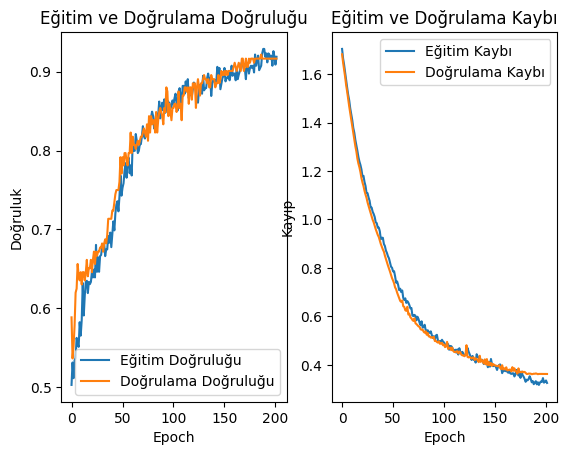

'# H5 TEST'

In [ ]:
## THE LAST AND BEST CODE UPGRADED IN CIZGI SYSTEM##

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

"""### Set all the Constants"""

BATCH_SIZE = 64
IMAGE_SIZE = 512
CHANNELS=3
EPOCHS=400



"""### Import data into tensorflow dataset object"""

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/Data_Sets/Grafikler/Çift_Grafikler/700_Sinirsiz_Cift/500_Train",
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names



def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_ds), len(val_ds), len(test_ds)))

"""### Cache, Shuffle, and Prefetch the Dataset"""

train_ds = train_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(50).prefetch(buffer_size=tf.data.AUTOTUNE)

"""## Building the Model

### Creating a Layer for Resizing and Normalization

"""

resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

"""### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
"""

data_augmentation = tf.keras.Sequential([
 #   layers.RandomFlip("horizontal_and_vertical"),
  #  layers.RandomRotation(0.2),
   # layers.RandomZoom(0.2),
     layers.RandomBrightness(0.2),
     #layers.GaussianNoise(0.1),
     #layers.RandomContrast(0.2),
])

"""#### Applying Data Augmentation to Train Dataset"""

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

"""### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.
"""

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), #input_shape=input_shape),
  #  layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
   # layers.Dropout(0.3),  # Dropout for regularization
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    #layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
   # layers.Dropout(0.3),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
   # layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
   # layers.Dropout(0.3),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
   # layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
   # layers.Dropout(0.3),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
   # layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
   # layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    #layers.Dropout(0.8),  # Dropout for regularization
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.8),  # Dropout for regularization
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

model.summary()

"""### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric
"""

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',
   factor=0.1,             # Öğrenme oranını %10 düşür
    patience=7,
    verbose=1,              # Mesajları yazdır
    mode='auto',
    min_delta=0.0001,       # bu deger kadar degisim olmazsa ogrenme oranini dusurur
    cooldown=0,             # Öğrenme oranı düşürüldükten sonra kaç epoch bekle
    min_lr=1e-7             # Öğrenme oranının düşebileceği minimum değer
)

# EarlyStopping callback'ini tanımlayın
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,              # Mesajları yazdır
    mode='auto',
    restore_best_weights=True  # En iyi ağırlıkları geri yükle  ,reduce_lr,
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

scores = model.evaluate(test_ds)

"""Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()



"""# H5 TEST"""

# H5 OLARAK KAYDETME

#model.save("/home/han/Downloads/deneme_20_.h5")



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from google.colab import drive
drive.mount('/content/drive')


"""### Set all the Constants"""

BATCH_SIZE = 32
IMAGE_SIZE = 512
CHANNELS=3
EPOCHS=200


"""### Import data into tensorflow dataset object"""

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/Data_Sets/Grafikler/Çift_Grafikler/700_Sinirsiz_Cift/500_Train",
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names



def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_ds), len(val_ds), len(test_ds)))

"""### Cache, Shuffle, and Prefetch the Dataset"""

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

"""## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it
"""

resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

"""### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
"""

#data_augmentation = tf.keras.Sequential([
 #   layers.RandomFlip("horizontal_and_vertical"),
  #  layers.RandomRotation(0.2),
   # layers.RandomZoom(0.2),
 #   layers.RandomBrightness(0.2),
#])

"""#### Applying Data Augmentation to Train Dataset"""

#train_ds = train_ds.map(
 #   lambda x, y: (data_augmentation(x, training=True), y)
#).prefetch(buffer_size=tf.data.AUTOTUNE)

"""### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.
"""

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

model.summary()

"""### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric
"""

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',     # Validation loss'u izle
   factor=0.1,             # Öğrenme oranını %10'a düşür
    patience=3,             # 5 epoch boyunca iyileşme olmazsa
    verbose=1,              # Mesajları yazdır
    mode='auto',            # 'min', 'max', 'auto'
    min_delta=0.0001,       # Yeni optimum için eşik
    cooldown=0,             # Öğrenme oranı düşürüldükten sonra kaç epoch bekle
    min_lr=1e-8             # Öğrenme oranının düşebileceği minimum değer
)

# EarlyStopping callback'ini tanımlayın
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Validation loss'u izle
    patience=15,            # 10 epoch boyunca iyileşme olmazsa eğitimi durdur
    verbose=1,              # Mesajları yazdır
    mode='auto',            # 'min', 'max', 'auto'
    restore_best_weights=True  # En iyi ağırlıkları geri yükle  ,reduce_lr,
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping,creduce_lr]
)

scores = model.evaluate(test_ds)

"""Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1000 files belonging to 2 classes.
Size of Data is :32 
Batch size of Training Data is :25
Batch size of Validation Data is :3 
Batch size of Testing Data is :4 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 255, 255, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 253, 64)        18496     
                     

In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/saved_model/Deneme_Çift_Sinirli_CNN_Model_%83.75, 0.38_.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1000 files belonging to 2 classes.
Size of Data is :32 
Batch size of Training Data is :25
Batch size of Validation Data is :3 
Batch size of Testing Data is :4 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 255, 255, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 253, 64)        18496     
                     

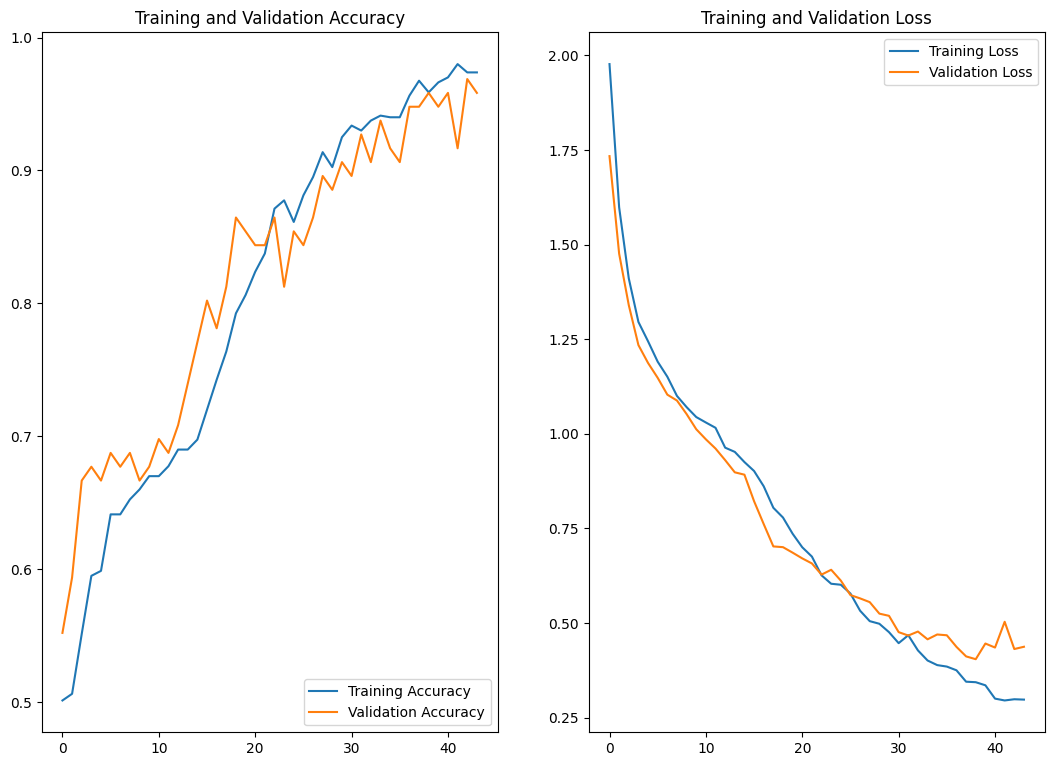

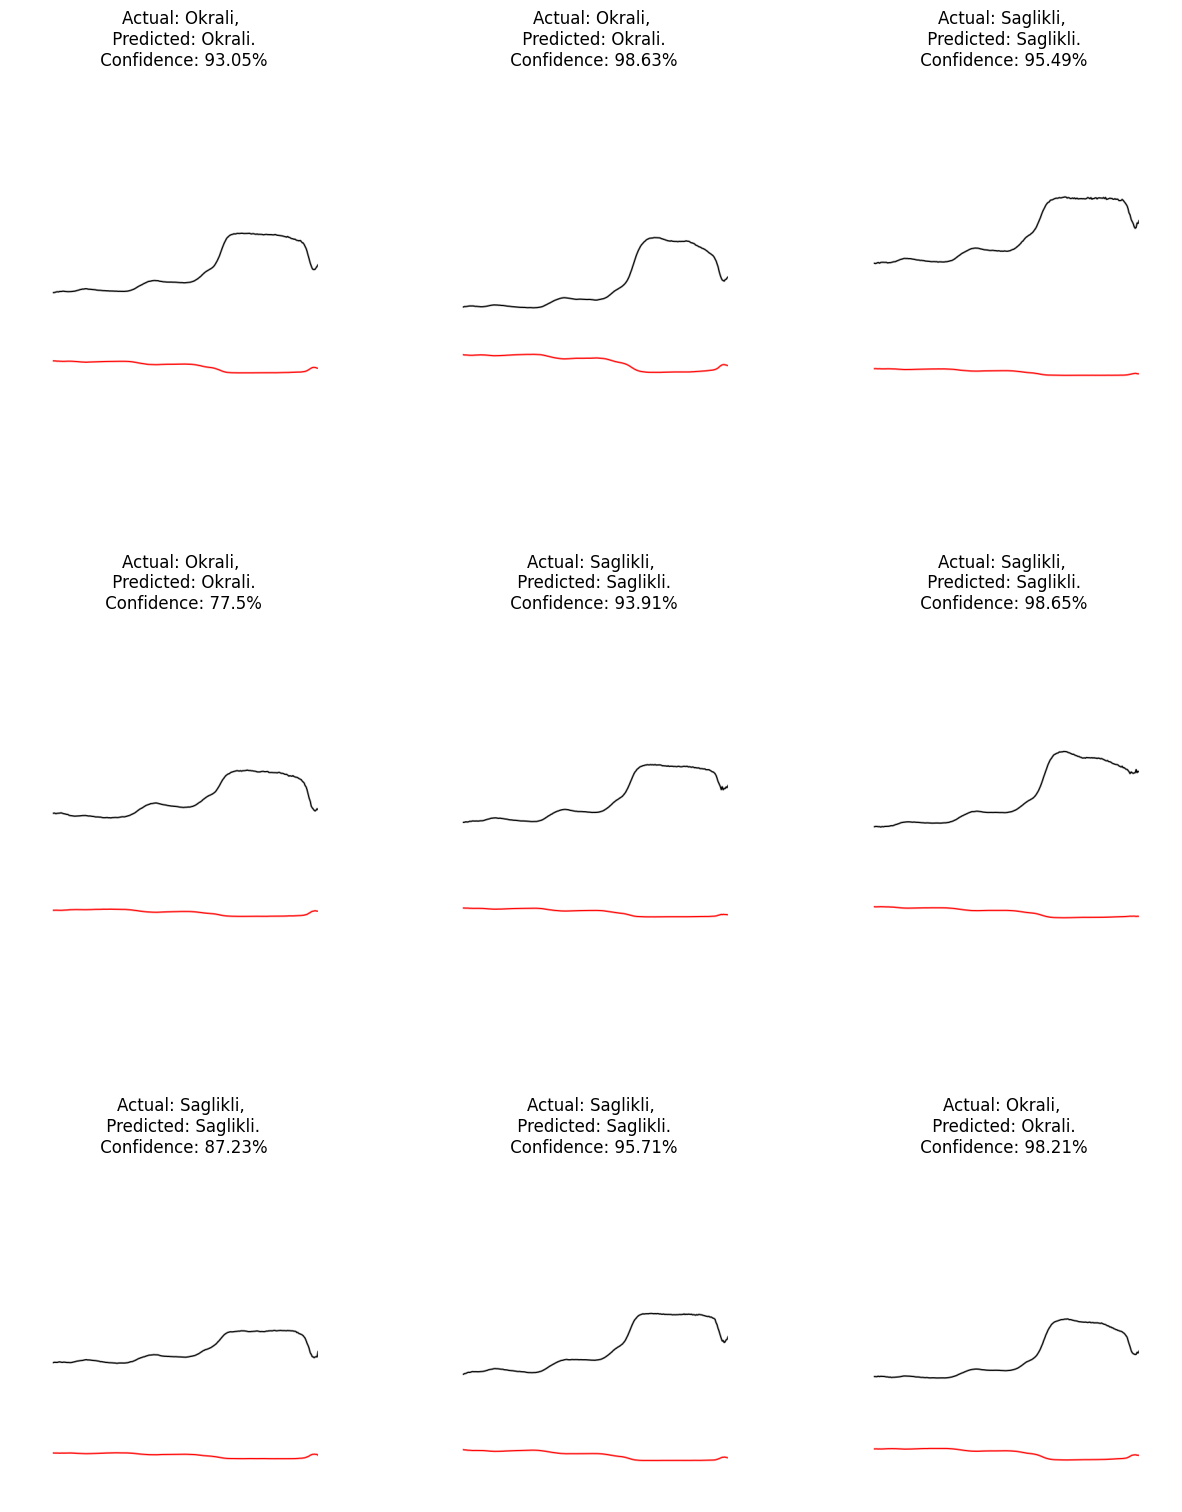

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
"""### Set all the Constants"""

BATCH_SIZE = 32
IMAGE_SIZE = 512
CHANNELS=3
EPOCHS=300

from google.colab import drive
drive.mount('/content/drive')

"""### Import data into tensorflow dataset object"""

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/Data_Sets/Grafikler/Çift_Grafikler/700_Sinirli_Cift/500_Train",
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names

"""### Visualize some of the images from our dataset"""

#plt.figure(figsize=(20, 20))
#for image_batch, labels_batch in dataset.take(1):
 #   for i in range(12):
  #      ax = plt.subplot(3, 4, i + 1)
   #     plt.imshow(image_batch[i].numpy().astype("uint8"))
    #    plt.title(class_names[labels_batch[i]])
     #   plt.axis("off")

"""**Train, Test, validation data split**"""

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=500):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_ds), len(val_ds), len(test_ds)))

"""### Cache, Shuffle, and Prefetch the Dataset"""

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(50).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(50).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation


data_augmentation = tf.keras.Sequential([
  layers.GaussianNoise(0.1),
  layers.RandomRotation(0.2),
])

"""#### Applying Data Augmentation to Train Dataset"""

#train_ds = train_ds.map(
 #   lambda x, y: (data_augmentation(x, training=True), y)
#).prefetch(buffer_size=tf.data.AUTOTUNE)

"""### Model Architecture
"""

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

model.summary()

"""### Compiling the Model
"""

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=1e-9
    )

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        mode='auto',
        restore_best_weights=True
    )


    # Train the model
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )



scores = model.evaluate(test_ds)


#Model Save


from tensorflow.keras.models import load_model
# model.save("/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/saved_model/Deneme_Çift_CNN_Model_10_.h5")

"""### Plotting the Accuracy and Loss Curves"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (20,20))
plt.subplot(2,3,1)
plt.plot(range(len(acc)), acc, label = 'Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(len(loss)), loss, label = 'Training Loss')
plt.plot(range(len(val_loss)), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

"""### Run prediction on a sample image"""

#import numpy as np
#for images_batch, labels_batch in test_ds.take(1):

 #   first_image = images_batch[0].numpy().astype('uint8')
  #  first_label = labels_batch[0].numpy()

   # print("first image to predict")
    #plt.imshow(first_image)
    #print("actual label:",class_names[first_label])

    #batch_prediction = model.predict(images_batch)
    #print("predicted label:",class_names[np.argmax(batch_prediction[0])])

"""### Write a function for inference"""

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

"""**Now run inference on few sample images**"""

plt.figure(figsize=(15, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


# Raisin Okra-Healthy Classification

### Import all the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib
from tensorflow.keras import regularizers


### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 512
CHANNELS=3
EPOCHS=300

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/Data_Sets/Grafikler/Çift_Grafikler/700_Sinirsiz_Cift/500_Train",
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1000 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Okrali', 'Saglikli']

### Visualize some of the images from our dataset

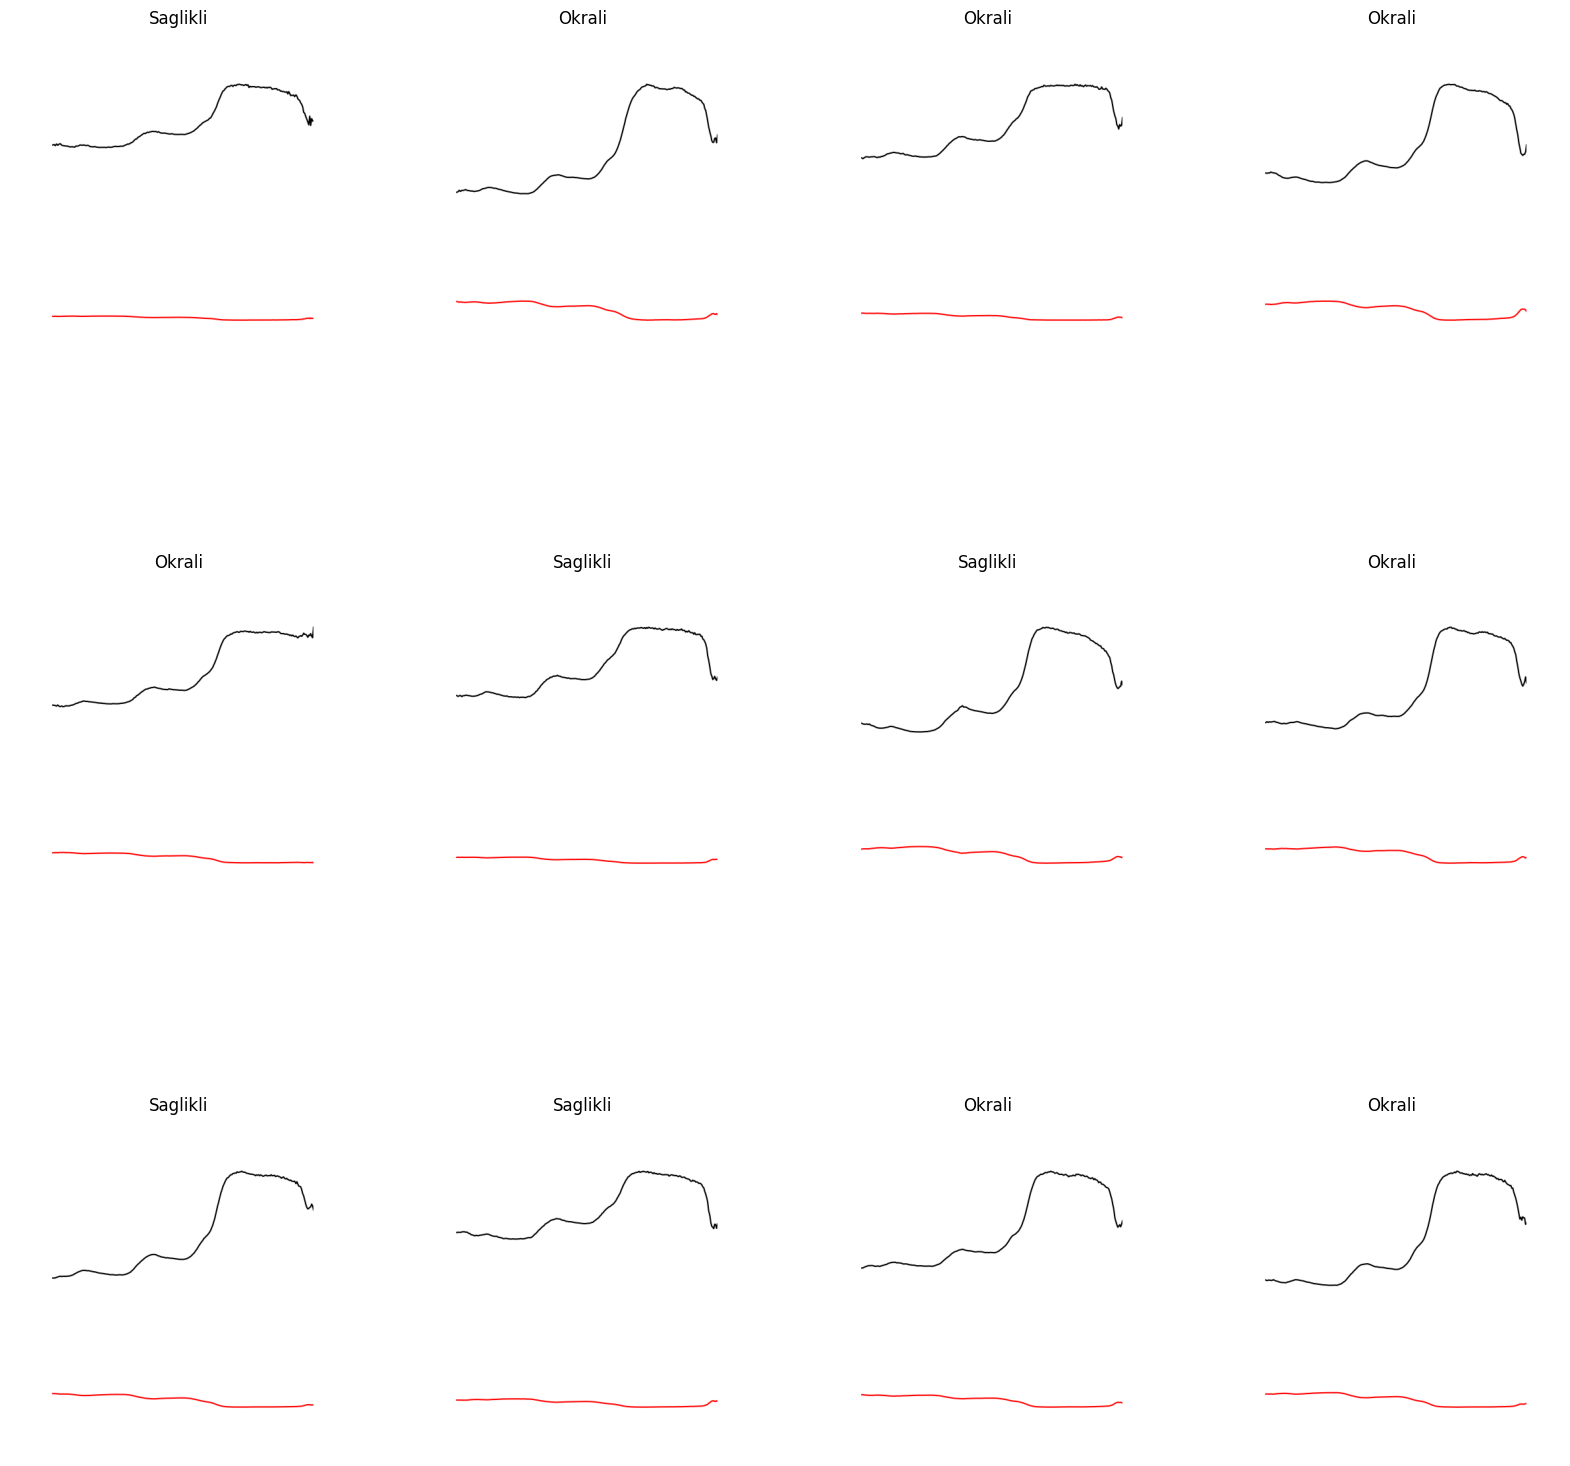

In [ ]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Train, Test, validation data split**

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_ds), len(val_ds), len(test_ds)))

Size of Data is :16 
Batch size of Training Data is :9
Batch size of Validation Data is :3 
Batch size of Testing Data is :4 


### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomBrightness(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.7),  # Dropout for regularization
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

NameError: name 'BATCH_SIZE' is not defined

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 509, 509, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2  (64, 254, 254, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 251, 251, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 125, 125, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (64, 122, 122, 128)      

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Early stopping tanımlama
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Validation loss'u izle
    patience=8,            # 10 epoch boyunca iyileşme olmazsa eğitimi durdur
    verbose=1,              # Mesajları yazdır
    mode='auto',            # 'min', 'max', 'auto'
    restore_best_weights=True  # En iyi ağırlıkları geri yükle  ,reduce_lr,
)

In [ ]:
# Decreasing Learning Rate

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',     # Validation loss'u izle
   factor=0.1,             # Öğrenme oranını %10'a düşür
    patience=3,             # 5 epoch boyunca iyileşme olmazsa
    verbose=1,              # Mesajları yazdır
    mode='auto',            # 'min', 'max', 'auto'
    min_delta=0.0001,       # Yeni optimum için eşik
    cooldown=0,             # Öğrenme oranı düşürüldükten sonra kaç epoch bekle
    min_lr=1e-7             # Öğrenme oranının düşebileceği minimum değer
)

NameError: name 'tf' is not defined

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
scores = model.evaluate(test_ds)

Scores is just a list containing loss and accuracy value

#Model Save

In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/saved_model/Deneme_Çift_Sinirli_CNN_Model_%83.75, 0.38_.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plotting the Accuracy and Loss Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

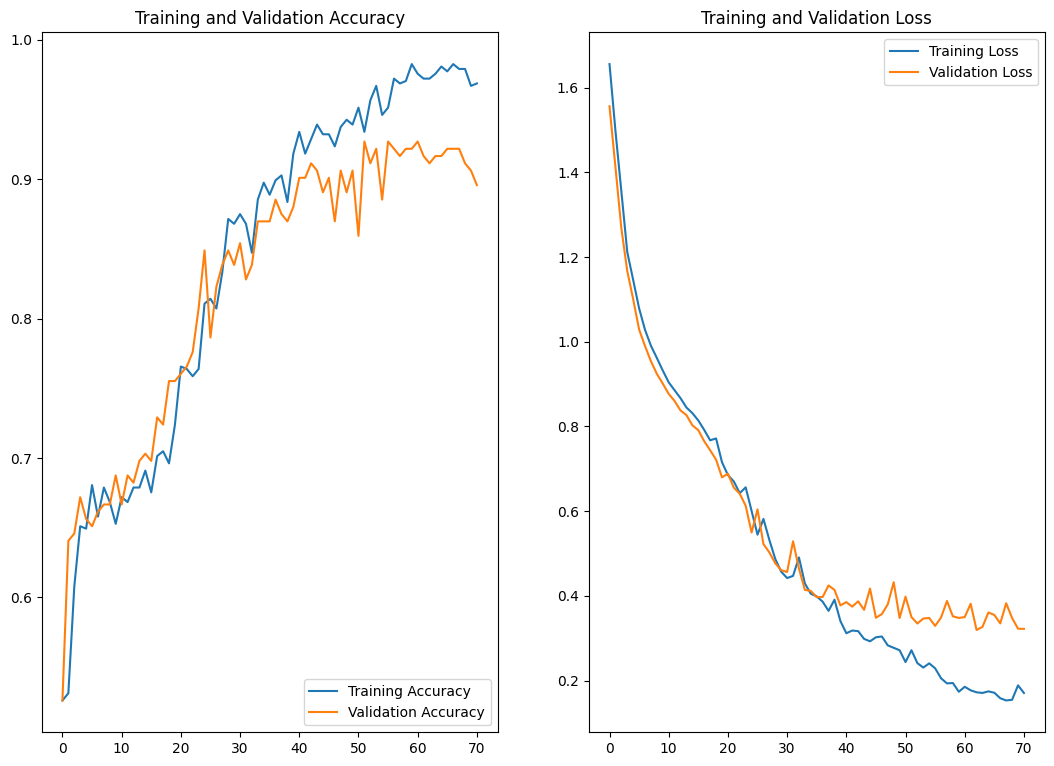

In [ ]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (20,20))
plt.subplot(2,3,1)
plt.plot(range(len(acc)), acc, label = 'Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(len(loss)), loss, label = 'Training Loss')
plt.plot(range(len(val_loss)), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

### Run prediction on a sample image

first image to predict
actual label: Okrali
3/3 [==============================] - 6s 1s/step
predicted label: Okrali


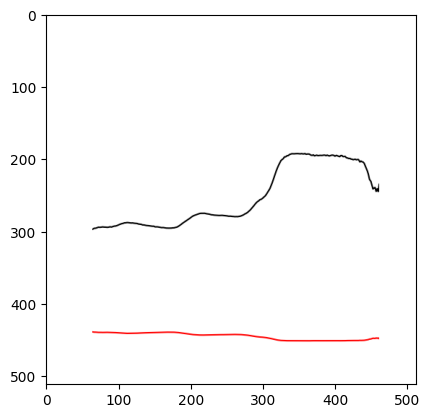

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 26ms/step


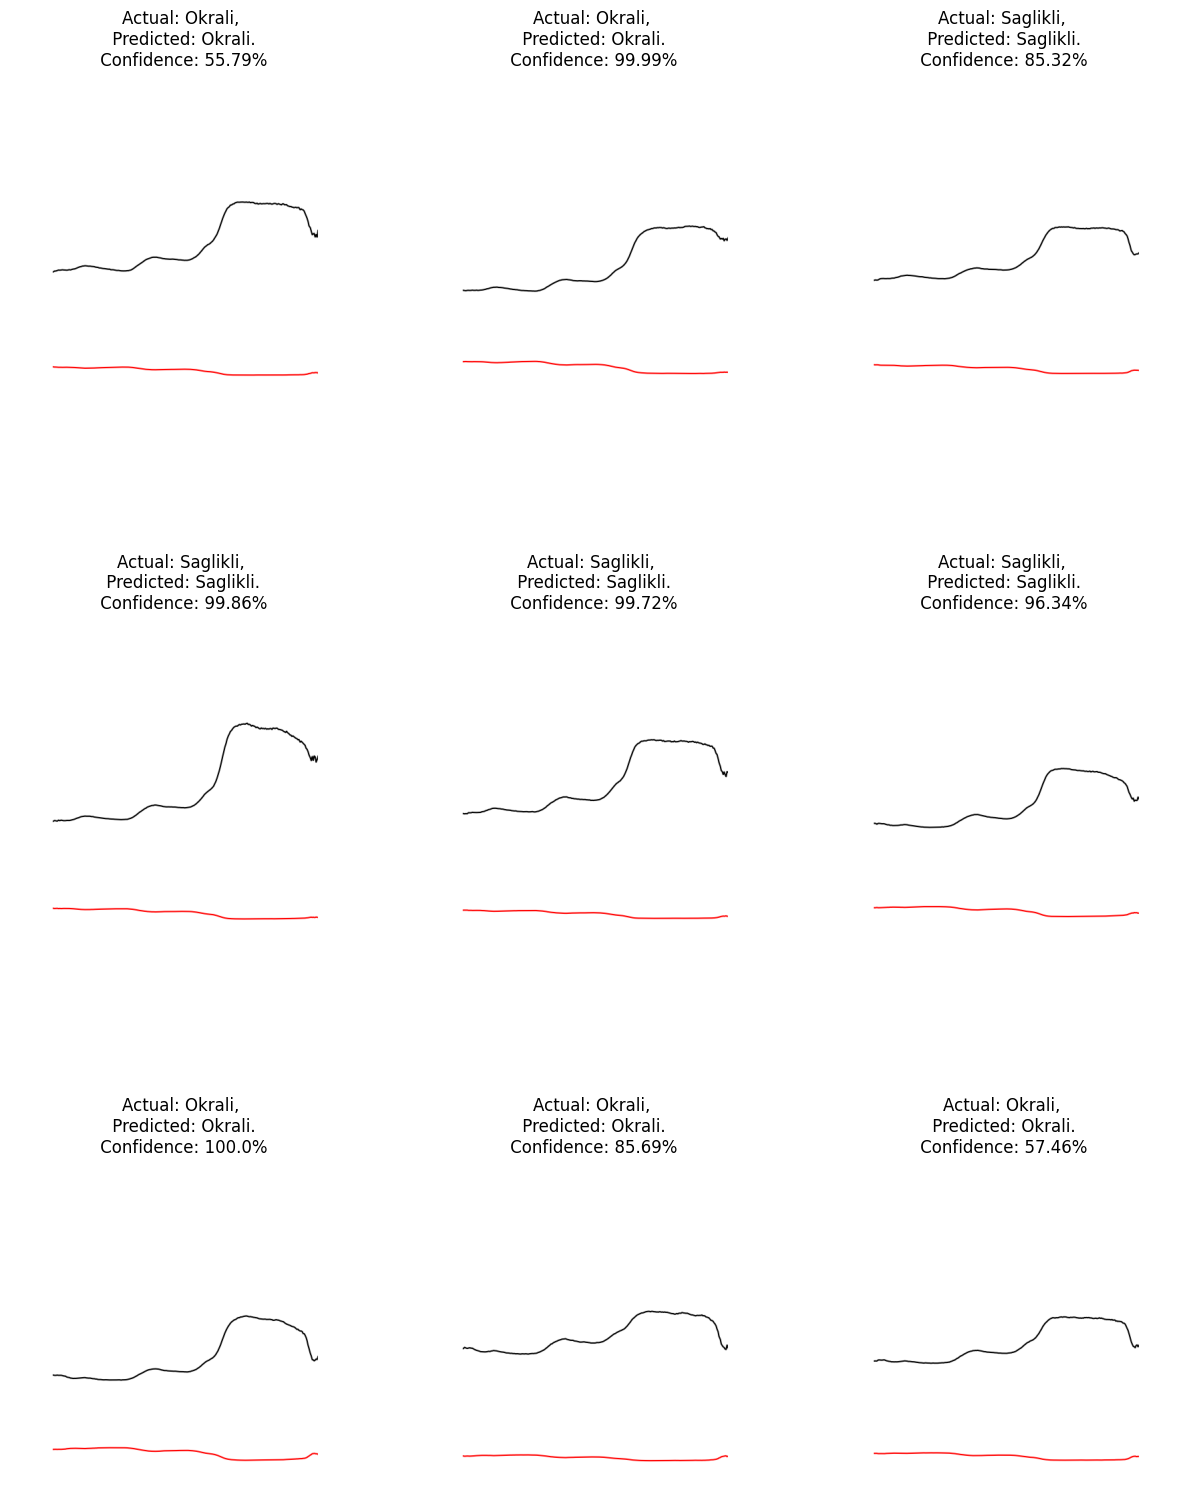

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# h5 Model Test Code

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Okra ve normal klasörlerinin yolları
okra_klasoru = "/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/Data_Sets/Grafikler/Çift_Grafikler/700_Sinirsiz_Cift/200_Test/Okrali"
normal_klasoru = "/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/Data_Sets/Grafikler/Çift_Grafikler/700_Sinirsiz_Cift/200_Test/Saglikli"

# Verileri ve etiketleri depolamak için boş listeler
X = []
y = []

# Okra verilerini yükleme ve etiketleme
for dosya_adi in os.listdir(okra_klasoru):
    dosya_yolu = os.path.join(okra_klasoru, dosya_adi)
    img = load_img(dosya_yolu, target_size=(512, 512))
    img_array = img_to_array(img)
    X.append(img_array)
    y.append(0)  # Okra sınıfı

# Normal verilerini yükleme ve etiketleme
for dosya_adi in os.listdir(normal_klasoru):
    dosya_yolu = os.path.join(normal_klasoru, dosya_adi)
    img = load_img(dosya_yolu, target_size=(512, 512))
    img_array = img_to_array(img)
    X.append(img_array)
    y.append(1)  # Normal sınıfı

# Veriyi ve etiketleri Numpy dizilerine dönüştürme
X = np.array(X)
y = np.array(y)

# Verileri karıştırma
sirali_indeksler = np.arange(X.shape[0])
np.random.shuffle(sirali_indeksler)
X = X[sirali_indeksler]
y = y[sirali_indeksler]

# Modeli yükleyip verileri tahmin etme
#model = load_model('/content/drive/MyDrive/AliBaki_TURKOZ_Engineering_Project/saved_model/Deneme_Çift_Sinirli_CNN_Model_2_.h5')  # Kaydedilmiş modeli yükleme
predictions = model.predict(X)  # Verileri tahmin etme

# Gerçek etiketlerin ve tahminlerin hazırlanması
true_labels = y
true_labels_cat = to_categorical(true_labels, num_classes=2)  # Gerçek etiketlerin kategorik hale getirilmesi
pred_prob_cat = predictions  # Tahmin olasılıklarının hesaplanması

# Doğruluk oranını ve kaybı hesaplama
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
loss = log_loss(true_labels_cat, pred_prob_cat)

print(f"Doğruluk Oranı: {accuracy}")
print(f"Kayıp: {loss}")

# Her aşamadaki tahmin ve gerçek etiketleri yazdırma
print("Tahminler ve Gerçek Etiketler:")
for i in range(len(true_labels)):
    print(f"Tahmin: {predictions[i]} - Gerçek Etiket: {true_labels[i]}")

# Accuracy oranlarının yazdırılması
accuracy_list = [accuracy_score(true_labels[:i+1], np.argmax(predictions[:i+1], axis=1)) for i in range(len(true_labels))]
print("Her Aşamadaki Accuracy Oranları:")
for i, acc in enumerate(accuracy_list):
    print(f"Veri sayısı: {i+1}, Accuracy: {acc}")

# Loss ve accuracy grafiğinin çizdirilmesi
loss_list = []
mean_loss_list = []
for i in range(len(true_labels)):
    loss_list.append(log_loss(true_labels_cat[:i+1], pred_prob_cat[:i+1]))
    mean_loss_list.append(np.mean(loss_list))  # Tüm epochlar için loss ortalaması alınıyor

# Accuracy'lerin ortalamasını alalım
mean_accuracy_list = [np.mean(accuracy_list[:i+1]) for i in range(len(accuracy_list))]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(len(true_labels)), accuracy_list, marker='o', linestyle='-', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Veri Sayısı')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(len(true_labels)), mean_loss_list, marker='o', linestyle='-', label='Mean Loss')
plt.title('Mean Loss')
plt.xlabel('Veri Sayısı')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(len(true_labels)), mean_accuracy_list, marker='o', linestyle='-', color='orange', label='Mean Accuracy')
plt.title('Mean Accuracy')
plt.xlabel('Veri Sayısı')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined